In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! wget nlp.stanford.edu/data/glove.6B.zip
! unzip glove.6B.zip

--2024-10-20 15:37:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-20 15:37:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-20 15:37:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!pip install contractions

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn, string, re, nltk, gensim, contractions, toolz
from sklearn.base import BaseEstimator, TransformerMixin
from toolz import pipe
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet, stopwords
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from gensim.models import Word2Vec,KeyedVectors
import gensim.downloader as api
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn import metrics

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
final_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kaggle/Essay scoring/train.csv')

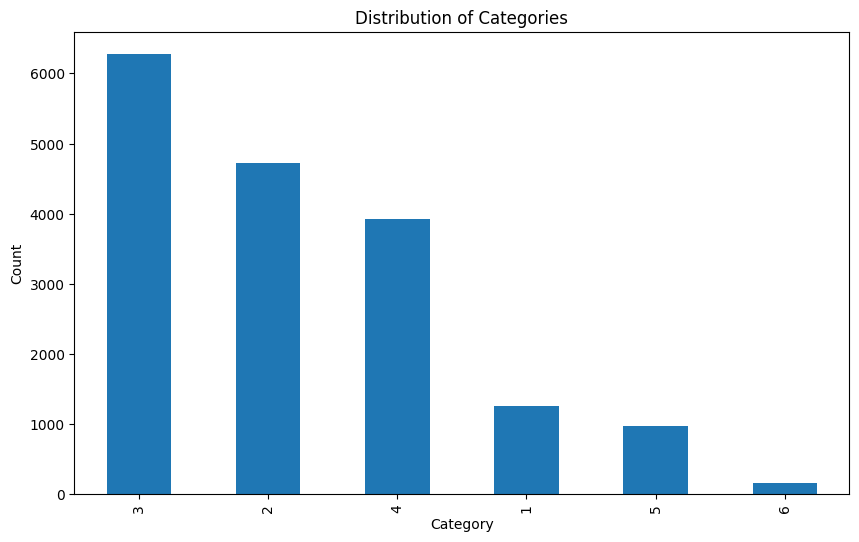

In [ ]:
plt.figure(figsize=(10, 6))
final_data['score'].value_counts().plot(kind='bar')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [ ]:
#@title Text Cleaning using Pipeline
class Lowercase(BaseEstimator, TransformerMixin): # A custom transformer class for lowerring the case for all words
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X.apply(lambda x: x.lower())

class Contractions(BaseEstimator, TransformerMixin): # Contract i.e. convert words like don't => do not
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X.apply(lambda x: contractions.fix(x))

class RemoveUrl(BaseEstimator, TransformerMixin): # Remove Url's
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X.apply(lambda x: re.sub(r"https?://\S+|www\.\S+", '', x))


class RemoveHtml(BaseEstimator, TransformerMixin): # Remove Html links
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return X.apply(lambda x: re.sub(r'[^\x00-\x7f]', r'', x))

class RemoveNonAscii(BaseEstimator, TransformerMixin): # Remove Non Ascii characters
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X.apply(lambda x: re.sub(r'[^\x00-\x7f]', r'', x))

class RemoveSpecialCharacters(BaseEstimator, TransformerMixin): # Remove the special characters like emojis, symbols, etc.
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return X.apply(lambda x: emoji_pattern.sub(r'', x))

class RemovePunctuation(BaseEstimator, TransformerMixin): # Remove punctuation marks
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    def replace_punctuation(text):  # Replace the commas with ' ' and rest other punctuations with ''
      translation_table = str.maketrans({',': ' '})
      text = text.translate(translation_table)
      text = text.translate(str.maketrans('', '', string.punctuation))
      return text

    # return X.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return X.apply(replace_punctuation)

class Stemming(BaseEstimator, TransformerMixin): # For stemming the words
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    return X.apply(lambda x: ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(x) if word not in stop_words]))

class Lemmatize(BaseEstimator, TransformerMixin): # For lemmatizing the words
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    return X.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x) if word not in stop_words]))

text_cleaning_pipe = Pipeline([
    ('lower', Lowercase()),
    ('contractions', Contractions()),
    ('remove_URL', RemoveUrl()),
    ('remove_html', RemoveHtml()),
    ('remove_non_ascii', RemoveNonAscii()),
    ('remove_special_characters', RemoveSpecialCharacters()),
    ('remove_punct', RemovePunctuation()),
    # ('stemming', Stemming()),
    ('lemmatize', Lemmatize())
])

text_cleaning_pipe.fit(final_data['full_text'], final_data['score'])

final_data['word_tokens'] = text_cleaning_pipe.transform(final_data['full_text'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_data['word_tokens'], final_data['score'], test_size=0.2, random_state=42)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=2,  max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                                   ngram_range=(1,2), use_idf=True, smooth_idf=True, sublinear_tf=True)

tfidf_vectorizer.fit(list(X_train) + list(X_test))
X_train_tfidf =  tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_tfidf = np.vstack(X_train_tfidf.to_numpy())
X_test_tfidf = np.vstack(X_test_tfidf.to_numpy())

In [ ]:
#### THIS IS BETTER THAN TFTDF

count_vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 3), stop_words = 'english')

count_vectorizer.fit(list(X_train) + list(X_test))
X_train_countVec =  count_vectorizer.transform(X_train)
X_test_countVec = count_vectorizer.transform(X_test)

# X_train_countVec = np.vstack(X_train_countVec.to_numpy())
# X_test_countVec = np.vstack(X_test_countVec.to_numpy())

In [ ]:
glove2word2vec('glove.6B.300d.txt', 'glove_word2vec.txt')

# Load the GloVe model
glove_model = KeyedVectors.load_word2vec_format('glove_word2vec.txt')

# Function to convert text to vector
def get_glove_embedding(text):
  words = text.split()
  word_vectors = []
  for word in words:
    if word in glove_model.key_to_index:
      word_vectors.append(glove_model[word])
  if word_vectors:
    return np.mean(word_vectors, axis=0)
  else:
    return np.zeros(300)  # Assuming 300-dimensional embeddings

# Apply the function to a DataFrame column
X_train_tfidf = X_train.apply(get_glove_embedding)
X_test_tfidf = X_test.apply(get_glove_embedding)

<ipython-input-9-9923360024d1>:1: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec('glove.6B.300d.txt', 'glove_word2vec.txt')


In [ ]:
smote = SMOTE(sampling_strategy='auto')
# X_resampled_tfidf, y_resampled_tfidf = smote.fit_resample(X_train_tfidf, y_train)
X_resampled_countVec, y_resampled_countVec = smote.fit_resample(X_train_countVec, y_train)

# adasyn = ADASYN(sampling_strategy='auto')
# X_resampled, y_resampled = adasyn.fit_resample(X_train_tfidf, y_train)

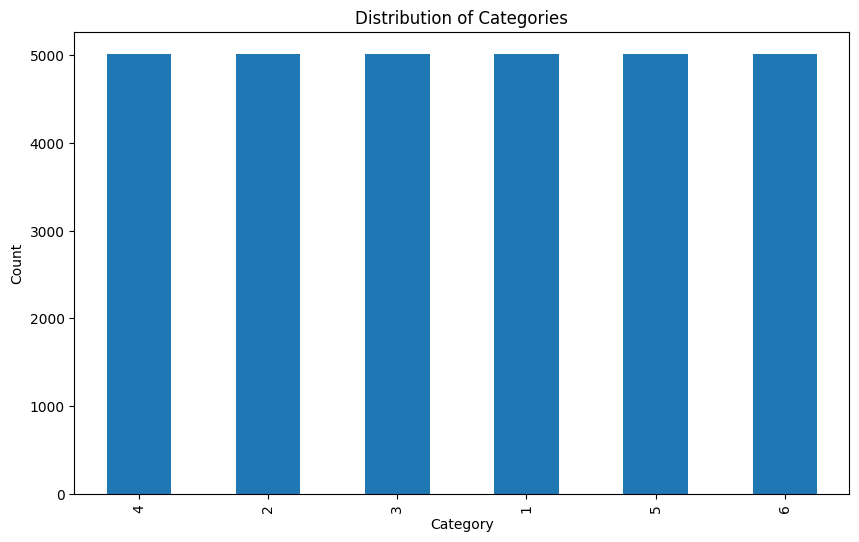

In [ ]:
plt.figure(figsize=(10, 6))
pd.Series(y_resampled_countVec).value_counts().plot(kind='bar')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [ ]:
model = LogisticRegression(C = 1, max_iter = 1000, n_jobs=-1)
model.fit(X_resampled_countVec, y_resampled_countVec)
y_pred = model.predict(X_test_countVec)
print("Accuracy: "+str(accuracy_score(y_test,y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 0.47978047371461585
              precision    recall  f1-score   support

           1       0.47      0.49      0.48       260
           2       0.59      0.62      0.60       965
           3       0.49      0.46      0.47      1265
           4       0.38      0.38      0.38       750
           5       0.31      0.38      0.34       183
           6       0.15      0.13      0.14        39

    accuracy                           0.48      3462
   macro avg       0.40      0.41      0.40      3462
weighted avg       0.48      0.48      0.48      3462



In [ ]:
mnb = MultinomialNB()
mnb.fit(X_resampled_countVec, y_resampled_countVec)
y_pred3 = mnb.predict(X_test_countVec)
print("Accuracy: "+str(accuracy_score(y_test,y_pred3)))
print(classification_report(y_test, y_pred3))

Accuracy: 0.3463316002310803
              precision    recall  f1-score   support

           1       0.51      0.30      0.38       260
           2       0.44      0.24      0.31       965
           3       0.41      0.35      0.37      1265
           4       0.31      0.52      0.39       750
           5       0.14      0.30      0.19       183
           6       0.08      0.21      0.12        39

    accuracy                           0.35      3462
   macro avg       0.32      0.32      0.29      3462
weighted avg       0.39      0.35      0.35      3462



In [ ]:
svc = LinearSVC()
svc.fit(X_resampled_countVec, y_resampled_countVec)
y_pred2 = svc.predict(X_test_countVec)
print("Accuracy: "+str(accuracy_score(y_test,y_pred2)))
print(classification_report(y_test, y_pred2))

Accuracy: 0.3833044482957828
              precision    recall  f1-score   support

           1       0.39      0.47      0.43       260
           2       0.45      0.45      0.45       965
           3       0.41      0.37      0.39      1265
           4       0.31      0.33      0.32       750
           5       0.25      0.27      0.26       183
           6       0.06      0.05      0.05        39

    accuracy                           0.38      3462
   macro avg       0.31      0.32      0.32      3462
weighted avg       0.38      0.38      0.38      3462



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, class_weight='balanced')
rfc.fit(X_train_tfidf,y_train)
y_pred4 = rfc.predict(X_test_tfidf)
print("Accuracy: "+str(accuracy_score(y_test,y_pred4)))
print(classification_report(y_test, y_pred4))

Accuracy: 0.4220103986135182
              precision    recall  f1-score   support

           1       0.31      0.59      0.40       260
           2       0.44      0.55      0.49       965
           3       0.53      0.20      0.29      1265
           4       0.43      0.59      0.50       750
           5       0.31      0.45      0.37       183
           6       0.00      0.00      0.00        39

    accuracy                           0.42      3462
   macro avg       0.34      0.40      0.34      3462
weighted avg       0.45      0.42      0.40      3462



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=1, verbose=1)
gbc.fit(X_train_tfidf, y_train)
y_pred5 = gbc.predict(X_test_tfidf)
print(accuracy_score(y_test, y_pred5))
print(classification_report(y_test, y_pred5))

      Iter       Train Loss   Remaining Time 
         1           1.4047           10.55m
         2           1.3737            8.30m
         3           1.3450            7.67m
         4           1.3204            7.52m
         5           1.2961            7.14m
         6           1.2751            6.88m
         7           1.2551            6.83m
         8           1.2358            6.72m
         9           1.2187            6.55m
        10           1.2015            6.39m
        20           1.0712            5.64m
        30           0.9858            4.88m
        40           0.9230            4.16m
        50           0.8721            3.46m
        60           0.8315            2.76m
        70           0.7949            2.07m
        80           0.7650            1.38m
        90           0.7389           41.13s
       100           0.7160            0.00s
0.53841709994223
              precision    recall  f1-score   support

           0       0.60    

In [ ]:
array = [1,2,3,4,5]

type(array)

list